In [2419]:
import os

In [2420]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\Loan-Amount-Prediction'

In [2421]:
os.chdir("../")

In [2422]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [2423]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path
    

In [2424]:
#import from constants and utils
from credit_risk.constants import *
from credit_risk.utils.common import read_yaml, create_directories

In [2425]:

#creating a Configuration class
class ConfigurationManager:
    def __init__(
        self,
        config_filepath   = CONFIG_FILE_PATH,
        params_filepath   = PARAMS_FILE_PATH,
        schema_filepath   = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)                       
        self.schema = read_yaml(schema_filepath)  
        
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)->DataTransformationConfig:
        config = self.config.data_transformation
        
        create_directories([config.root_dir])
        
        data_transformation_config = DataTransformationConfig(
            root_dir  = config.root_dir,
            data_path = config.data_path,
        )
        
        return data_transformation_config
    
       

In [ ]:
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
from credit_risk import logger
import matplotlib.pyplot as plt
import seaborn as sns   



In [2427]:
project_path = "C:/Users/RICH-FILES/Desktop/ml/Loan-Amount-Prediction"

os.chdir(project_path)

In [ ]:
   #transform categorical data and stardardize the data
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline   
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

        

In [ ]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        
     # add EDA to the data 
    def data_cleaning(self):
        data = pd.read_csv(self.config.data_path)
        
        #remove  columns which are not necessary for the analysis
        data.drop(columns = ["Id","Status", "Default"], inplace=True)
        
        
        data.dropna(inplace=True)
        
        print("...............................................................")
        #drop null values
        print(data.isnull().sum())
        
        print("...............................................................")
        
        
        
        logger.info(f"Null values dropped")
        
        print("................................................................")
        print()
        
        
        
        #remove outliers
        data = data[(data['Age'] < 80) & (data['Emp_length'] < 10) & (data['Income'] < 948000)]
        
        
        print("data.head()")
        
        print(data.head())
        
        print("...................................................................")
        
        data1  = data
        
        return data1

        logger.info(f"Data cleaning complete")
        
    
      
        
    def exploratory_data_analysis(self):
        data1 = pd.read_csv(self.config.data_path)
        
        data1 = data1[(data1['Age'] < 80) & (data1['Emp_length'] < 10) & (data1['Income'] < 948000)]
        
        #check descriptive statistics
        
        print(data1.describe())
        
        #check non numeric columns
        print(data1.describe(include='object'))
        
        #check the target variable
        data1['Amount'].hist()
        plt.ylabel('Count')
        plt.xlabel('Amount')    
        plt.title('Loan Amount Distribution')
        
        
        print("The distribution is right-skewed, meaning most loan amounts fall in the lower range (below 10,000), while fewer loans exist at higher amounts");
                
        #calculate Amount distribution by Age   
        plt.figure(figsize=(12,6))
        sns.scatterplot(x='Age', y='Amount', data=data1) 
        plt.xlabel('Age')
        plt.ylabel('Amount')            
        plt.title('Loan Amount by Age'); 
        
        # calculating Amount distribution by Income
        plt.figure(figsize=(12,6))
        sns.scatterplot(x='Income', y='Amount', data=data1)    
        plt.xlabel('Income')
        plt.ylabel('Amount')
        plt.title('Loan Amount by Income');
        
        #loan purpose count
        plt.figure(figsize=(12,6))
        data1["Intent"].value_counts().plot(kind='bar')
        plt.ylabel('Count')
        plt.xlabel('Intent')
        plt.title('Loan Intent Distribution');
        
        #check multicollinearity and correlation
        plt.figure(figsize=(12,6))  
        corr = data1.select_dtypes(include=['int64', 'float64']).drop('Amount', axis=1).corr()    
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix');
        
        #drop column Id and Cred_length , Status, Default   
        columns_to_drop = ["Id", "Cred_length", "Status", "Default"]
        data1.drop(columns=[col for col in columns_to_drop if col in data1.columns], inplace=True)
        pd.options.mode.copy_on_write=True
        print(data1.head())
        
        data2 = data1
        
        return data2
        
    def feat_engineering(self):
        data2 = pd.read_csv(self.config.data_path)
        
        #feature engineering
        cat_features    = data2[["Home", "Intent"]]
        num_features   = data2[["Age",	"Income", "Emp_length", "Amount","Rate", 	"Percent_income"]]
        
        
        # instantiate the column StandardScaler
        numerical_processor = Pipeline(
            steps =[("standard scaling",  StandardScaler()
            )]  
        )
        
        # instantiate the column OneHotEncoder
        categorical_processor = Pipeline(
            steps =[("one hot encoding", OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            )]  
        )
    
        #implement the column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                
                ("numerical", numerical_processor, num_features.columns),
                ("categorical", categorical_processor, cat_features.columns)
            ]
        )   
 
        #fit the preprocessor
        preprocessor.fit(data2)
        
        
        #transform the data
        transformed_data=preprocessor.transform(data2)  

        data2=pd.DataFrame(transformed_data)
        data2.columns = num_features.columns.tolist() + preprocessor.named_transformers_["categorical"]["one hot encoding"].get_feature_names_out().tolist()
        data2.to_csv("artifacts/data_ingestion/credit_risk.csv", index=False)   
        
        print(data2.head())
        
      

        data3 = data2
        
        
        return data3 
            
        
        
    def train_test_splitting(self):
        data3 = pd.read_csv(self.config.data_path)
        
        #split the data into train and test
        train, test = train_test_split(data3, test_size=0.2, random_state=42)  
        
        train.to_csv(os.path.join(self.config.root_dir, 'train.csv'), index=False)
        test.to_csv(os.path.join(self.config.root_dir, 'test.csv'), index=False)        #save the train and test data to the root directory     
        
        logger.info("Data split into train and test data")  
        logger.info(f"Train data shape: {train.shape}")         
        logger.info(f"Test data shape: {test.shape}")  
        
        print(train.shape)
        print(test.shape)                
    


[2025-03-07 23:32:59,761: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-07 23:32:59,765: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-07 23:32:59,769: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-07 23:32:59,771: INFO: common: created directory at: artifacts]
[2025-03-07 23:32:59,773: INFO: common: created directory at: artifacts/data_transformation]
...............................................................
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Percent_income    0
Cred_length       0
dtype: int64
...............................................................
[2025-03-07 23:32:59,856: INFO: 2254593239: Null values dropped]
................................................................

data.head()
   Age  Income      Home  Emp_length     Intent  Amount   Rate  \
1   21    9600       OWN         5.0  EDUCATI

ValueError: not enough values to unpack (expected 3, got 2)

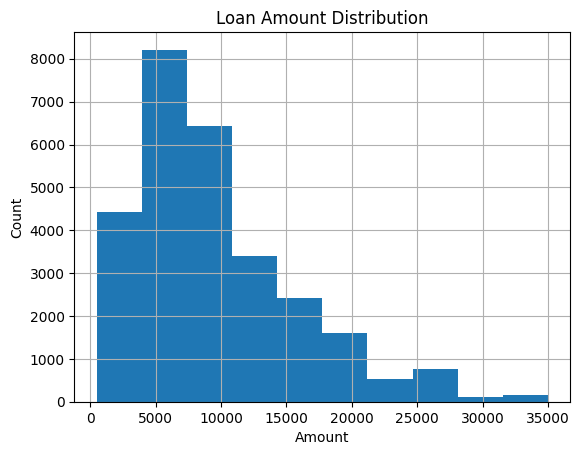

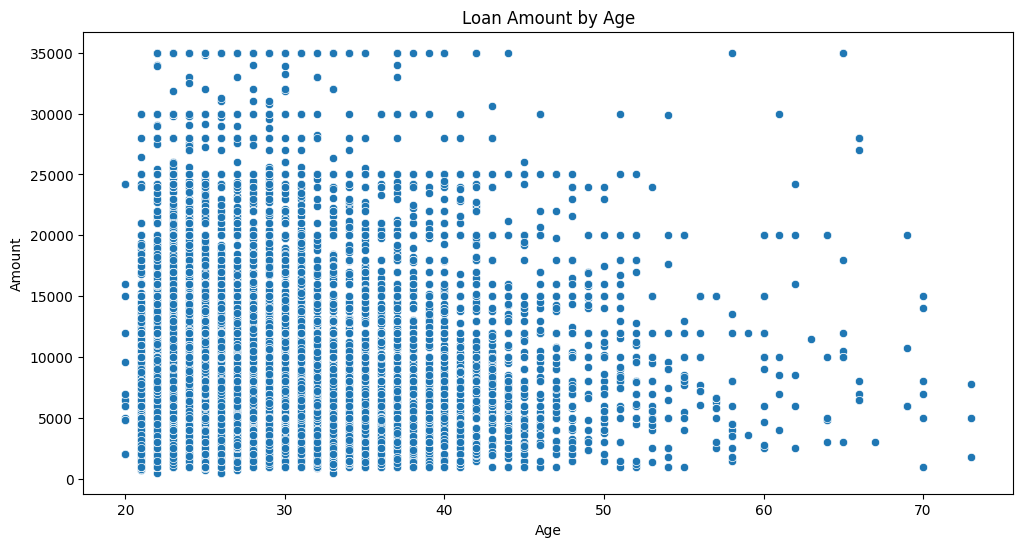

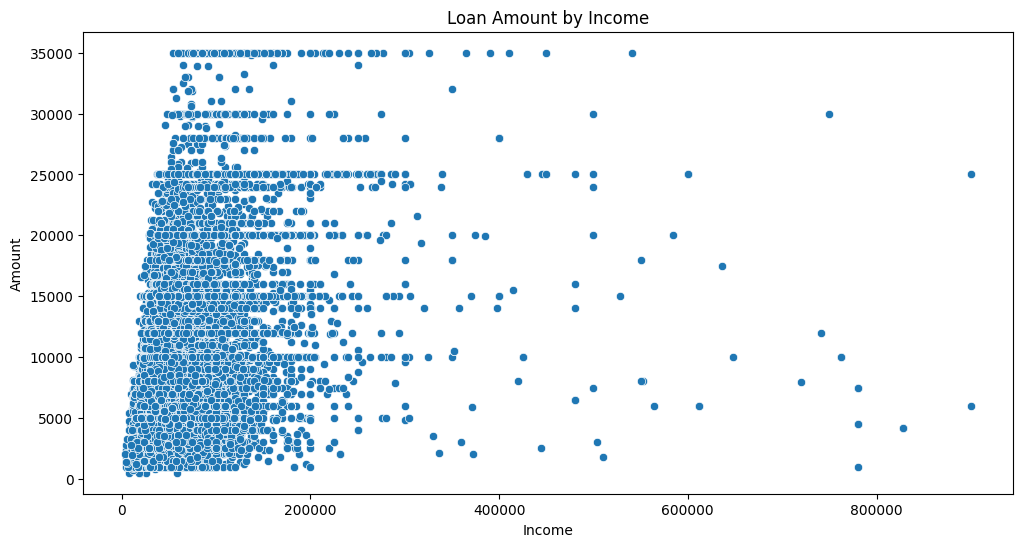

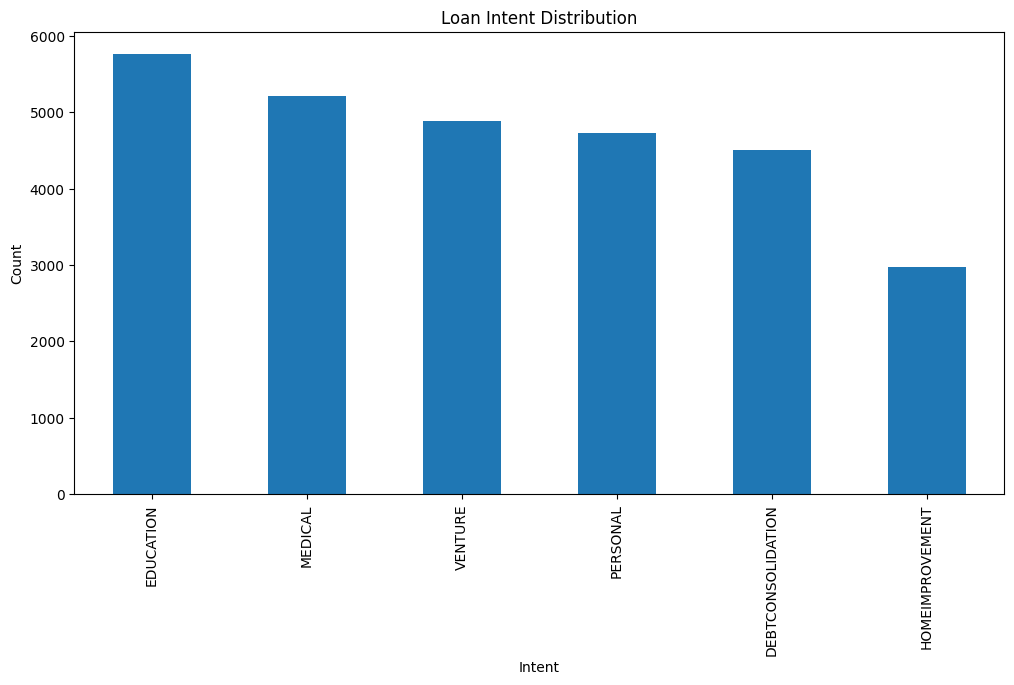

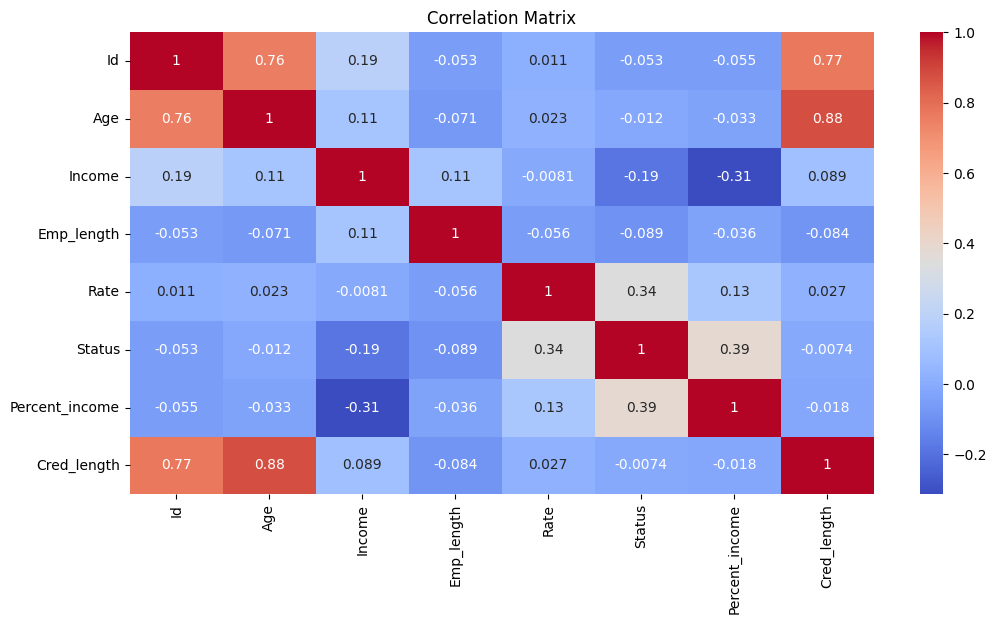

In [2430]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config() 
    data_transformation = DataTransformation(config = data_transformation_config)
    data_transformation.data_cleaning()
    data_transformation.exploratory_data_analysis()
    data_transformation.feat_engineering()
    data_transformation.train_test_splitting()
except Exception as e:
    raise e